<a href="https://colab.research.google.com/github/AlexandreAdam/Censai/blob/eager2.4/notebooks/train_raytracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RayTracer

Uncomment the following block to start

In [1]:
!git clone https://github.com/AlexandreAdam/Censai.git
%cd Censai
!git checkout eager2.4
!python setup.py install

Cloning into 'Censai'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 530 (delta 40), reused 68 (delta 19), pack-reused 427
Receiving objects: 100% (530/530), 13.45 MiB | 32.95 MiB/s, done.
Resolving deltas: 100% (273/273), done.
/content/Censai
Branch 'eager2.4' set up to track remote branch 'eager2.4' from 'origin'.
Switched to a new branch 'eager2.4'
running install
running bdist_egg
running egg_info
creating censai.egg-info
writing censai.egg-info/PKG-INFO
writing dependency_links to censai.egg-info/dependency_links.txt
writing top-level names to censai.egg-info/top_level.txt
writing manifest file 'censai.egg-info/SOURCES.txt'
writing manifest file 'censai.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/censai
copying censai/physical_model.py -> build/lib/cens

In [2]:
# wanb login, uncomment 
%pip install wandb -q
import wandb


     |████████████████████████████████| 2.0MB 19.0MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 133kB 57.1MB/s 
     |████████████████████████████████| 163kB 61.4MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 


In [13]:
import tensorflow as tf
from censai.definitions import RayTracer
from censai.data_generator import NISGenerator
from datetime import datetime
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
%matplotlib inline
os.mkdir(Config.logdir) # run only once

In [124]:
def main(args):
    if wndb:
        config = wandb.config
        config.learning_rate = args.lr
        config.batch_size = args.batch_size
        config.epochs = args.epochs
        config.architecture="RayTracer UNET"
        config.update(args)
    gen = NISGenerator(args.total_items, args.batch_size, src_side_pixels=args.pixels)
    # gen_test = NISGenerator(args.validation, args.validation, train=False, src_side_pixels=args.pixels)
    ray_tracer = RayTracer()
    optim = tf.keras.optimizers.Adam(learning_rate=args.schedule)

    # setup tensorboard writer (nullwriter in case we do not want to sync)
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, args.logname)
        traindir = os.path.join(logdir, "train")
        # testdir = os.path.join(logdir, "test")
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        if not os.path.isdir(traindir):
            os.mkdir(traindir)
        # if not os.path.isdir(testdir):
            # os.mkdir(testdir)
        train_writer = tf.summary.create_file_writer(traindir)
        # test_writer = tf.summary.create_file_writer(testdir)
    else:
        # test_writer = nullwriter()
        train_writer = nullwriter()

    epoch_loss = tf.metrics.Mean()
    best_loss = np.inf
    patience = args.patience
    step = 1
    if args.kappalog:
      link = lambda x: tf.math.log(x) / tf.math.log(10.)
      invlink = lambda x: 10.**(x)
    else:
      link = lambda x: x
      invlink = lambda x: x
    for epoch in range(1, args.epochs + 1):
        epoch_loss.reset_states()
        with train_writer.as_default():
            for batch, (kappa, alpha) in enumerate(gen):
                with tf.GradientTape() as tape:
                    tape.watch(ray_tracer.trainable_variables)
                    cost = ray_tracer.cost(link(kappa), alpha) # call + MSE loss function
                    # cost += tf.reduce_sum(ray_tracer.losses) # add regularizer loss
                gradient = tape.gradient(cost, ray_tracer.trainable_variables)
                # clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
                optim.apply_gradients(zip(gradient, ray_tracer.trainable_variables)) # backprop

                #========== Summary and logs ==========
                epoch_loss.update_state([cost])
                tf.summary.scalar("MSE", cost, step=step)
                step += 1
            tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
        # with test_writer.as_default():
        #     for (kappa, alpha) in gen_test:
        #         test_cost = ray_tracer.cost(kappa, alpha)
        #     tf.summary.scalar("MSE", test_cost, step=step)
        print(f"epoch {epoch} | train loss {epoch_loss.result().numpy():.3e} | learning rate {optim.lr(step).numpy():.2e}")
        if epoch_loss.result() < best_loss - args.tolerance:
          best_loss = epoch_loss.result()
          patience = args.patience
        else:
          patience -= 1
        if patience == 0:
          print("Reached patience")
          break

    return gen, gen_test, ray_tracer, epoch_loss.result()

In [125]:
# quick hack to make a config like args of ArgumentParser
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

lr = 1e-7
decay_steps=100
decay_rate=1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
# setup hyperparameter and other configs
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
Config = AttrDict()
Config.update({
    #hparams
    "epochs": 1000,
    "lr": lr, # initial learning rate
    "decay_steps": decay_steps,
    "decay_rate": decay_rate,
    "batch_size": 20,
    "kappalog": False,
    "clipping": False,
    "pixels": 256,
    #configs
    "total_items": 1000, # items per epochs
    "logdir": "logs",
    "logname": date,
    # "validation": 100,
    "patience": 40,
    "tolerance": 0,
    "schedule": lr_schedule,
})

In [126]:
wndb = True
wandb.init(project="censai", entity="adam-alexandre01123", sync_tensorboard=True)
gen, gen_test, ray_tracer, loss = main(Config)
ray_tracer.save

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


epoch 1 | train loss 5.818e+00 | learning rate 1.00e-07
epoch 2 | train loss 5.963e+00 | learning rate 1.00e-07
epoch 3 | train loss 5.743e+00 | learning rate 1.00e-07
epoch 4 | train loss 5.949e+00 | learning rate 1.00e-07
epoch 5 | train loss 5.965e+00 | learning rate 1.00e-07
epoch 6 | train loss 5.713e+00 | learning rate 1.00e-07
epoch 7 | train loss 6.001e+00 | learning rate 1.00e-07
epoch 8 | train loss 5.766e+00 | learning rate 1.00e-07
epoch 9 | train loss 5.889e+00 | learning rate 1.00e-07
epoch 10 | train loss 5.910e+00 | learning rate 1.00e-07
epoch 11 | train loss 5.941e+00 | learning rate 1.00e-07


KeyboardInterrupt: ignored

In [117]:
kap, alp = gen[0]

In [118]:
if Config.kappalog:
  link = lambda x: tf.math.log(x) / tf.math.log(10.)
  invlink = lambda x: 10.**(x)
else:
  link = lambda x: x
  invlink = lambda x: x

alpha_pred = ray_tracer(link(kap))

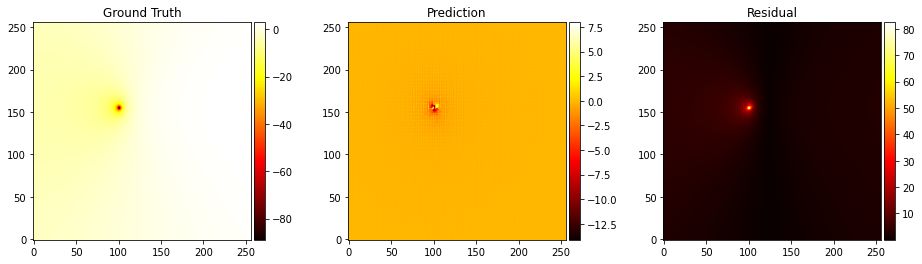

In [119]:
ind = 4
dim = 0


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
im = ax1.imshow(alp.numpy()[ind, ..., dim], cmap="hot", origin="lower")
divider = make_axes_locatable(ax1)
cax    = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im,cax=cax)   
ax1.set_title("Ground Truth")

im = ax2.imshow(alpha_pred.numpy()[ind, ..., dim], cmap="hot", origin="lower")
divider = make_axes_locatable(ax2)
cax    = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im,cax=cax)   
ax2.set_title("Prediction")


residual = np.abs(alpha_pred.numpy()[ind, ..., dim] - alp.numpy()[ind, ..., dim])
im = ax3.imshow(residual, cmap="hot", origin="lower")
divider = make_axes_locatable(ax3)
cax    = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im,cax=cax)
ax3.set_title("Residual")

pass

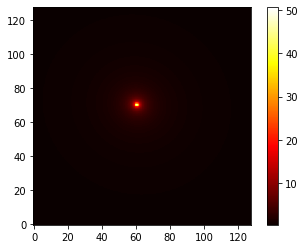

In [108]:
plt.imshow(kap.numpy()[ind, ..., 0], cmap="hot", origin="lower")
plt.colorbar()
pass